In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import bisect
from math import erf
import time

# FIG-1:

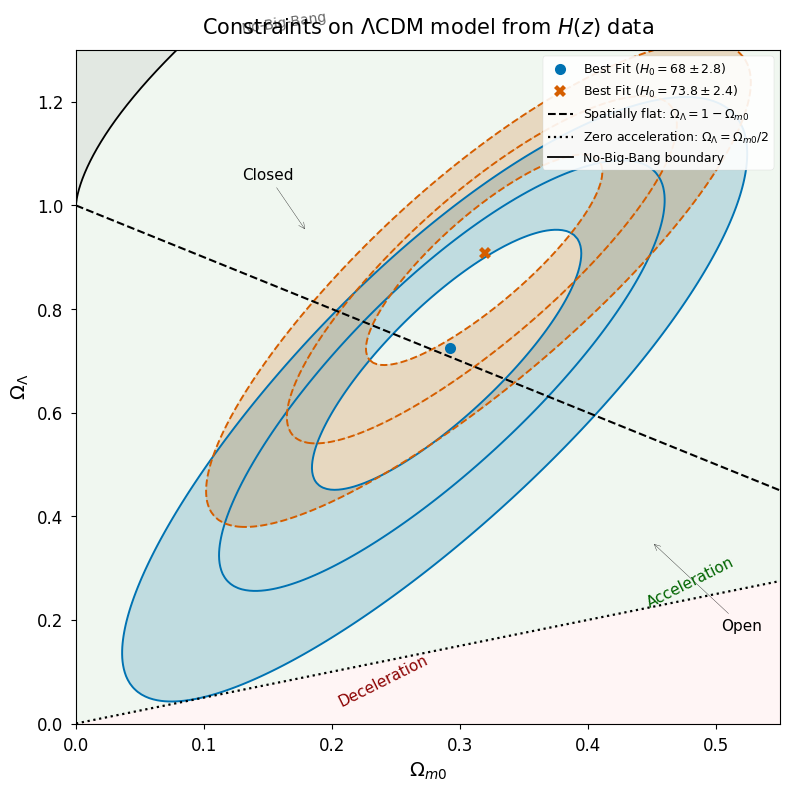


      Numerical Results for ΛCDM Model Fit

--- Prior 1: H0 = 68.0 +/- 2.8 km/s/Mpc ---
Best-fit point (Ωm0, ΩΛ): (0.29, 0.72)
Minimum χ2: 16.38
2σ interval for Ωm0: 0.15 <= Ωm0 <= 0.43
2σ interval for ΩΛ:  0.36 <= ΩΛ <= 1.02

--- Prior 2: H0 = 73.8 +/- 2.4 km/s/Mpc ---
Best-fit point (Ωm0, ΩΛ): (0.32, 0.91)
Minimum χ2: 17.75
2σ interval for Ωm0: 0.20 <= Ωm0 <= 0.44
2σ interval for ΩΛ:  0.62 <= ΩΛ <= 1.15



In [6]:
def calculate_chi2_marginalized(om_m0, om_l, z, H_obs, sigma_H, prior):
    if om_m0 < 0:
        return np.inf
    om_k0 = 1.0 - om_m0 - om_l
    E_sq = om_m0 * (1 + z)**3 + om_k0 * (1 + z)**2 + om_l
    if np.any(E_sq < 0):
        return np.inf
    E = np.sqrt(E_sq)
    A_sum = np.sum(E**2 / sigma_H**2)
    B_sum = np.sum(H_obs * E / sigma_H**2)
    C_sum = np.sum(H_obs**2 / sigma_H**2)
    sigma_H0_sq = prior['H0_sigma']**2
    H0_mean = prior['H0_mean']
    S_A = A_sum + 1 / sigma_H0_sq
    S_B = B_sum + H0_mean / sigma_H0_sq
    S_C = C_sum + H0_mean**2 / sigma_H0_sq
    chi2_val = S_C - S_B**2 / S_A
    return chi2_val

def get_1d_intervals(chi2_grid, x_grid, y_grid, min_chi2, delta_chi2):
    chi2_1d_x = np.min(chi2_grid, axis=0) # Marginalize over y-axis
    x_mask = (chi2_1d_x - min_chi2) < delta_chi2
    x_interval = (x_grid[x_mask].min(), x_grid[x_mask].max()) if np.any(x_mask) else (np.nan, np.nan)
    chi2_1d_y = np.min(chi2_grid, axis=1) # Marginalize over x-axis
    y_mask = (chi2_1d_y - min_chi2) < delta_chi2
    y_interval = (y_grid[y_mask].min(), y_grid[y_mask].max()) if np.any(y_mask) else (np.nan, np.nan)
    return x_interval, y_interval
def main():
    try:
        data = pd.read_csv('hz_28points.csv')
        z_obs = data['z'].values
        H_obs = data['H_obs'].values
        sigma_H = data['sigma_H'].values
    except FileNotFoundError:
        print("Error: 'hz_28points.csv' not found.")
        return
    prior1 = {'H0_mean': 68, 'H0_sigma': 2.8}
    prior2 = {'H0_mean': 73.8, 'H0_sigma': 2.4}

    om_m0_grid = np.linspace(0, 0.6, 200)
    om_l_grid = np.linspace(0, 1.4, 200)
    chi2_1 = np.zeros((len(om_l_grid), len(om_m0_grid)))
    chi2_2 = np.zeros((len(om_l_grid), len(om_m0_grid)))

    for i, om_l in enumerate(om_l_grid):
        for j, om_m0 in enumerate(om_m0_grid):
            chi2_1[i, j] = calculate_chi2_marginalized(om_m0, om_l, z_obs, H_obs, sigma_H, prior1)
            chi2_2[i, j] = calculate_chi2_marginalized(om_m0, om_l, z_obs, H_obs, sigma_H, prior2)

    min_chi2_1 = np.min(chi2_1)
    idx1 = np.unravel_index(np.argmin(chi2_1), chi2_1.shape)
    best_fit_1 = (om_m0_grid[idx1[1]], om_l_grid[idx1[0]])
    min_chi2_2 = np.min(chi2_2)
    idx2 = np.unravel_index(np.argmin(chi2_2), chi2_2.shape)
    best_fit_2 = (om_m0_grid[idx2[1]], om_l_grid[idx2[0]])

    levels_1 = min_chi2_1 + np.array([2.30, 6.18, 11.83])
    levels_2 = min_chi2_2 + np.array([2.30, 6.18, 11.83])

    # plotting

    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(8, 8))
    X, Y = np.meshgrid(om_m0_grid, om_l_grid)

    color1 = '#0072B2'
    color2 = '#D55E00'
    ax.contourf(X, Y, chi2_1, levels=levels_1, colors=[color1], alpha=0.20)
    ax.contourf(X, Y, chi2_2, levels=levels_2, colors=[color2], alpha=0.20)
    ax.contour(X, Y, chi2_1, levels=levels_1, colors=color1, linewidths=1.4)
    ax.contour(X, Y, chi2_2, levels=levels_2, colors=color2, linewidths=1.4, linestyles='--')

    ax.plot(best_fit_1[0], best_fit_1[1], 'o', color=color1, markersize=8, markeredgecolor='k', label=r'Best Fit ($H_0 = 68 \pm 2.8$)')
    ax.plot(best_fit_2[0], best_fit_2[1], 'X', color=color2, markersize=8, markeredgecolor='k', label=r'Best Fit ($H_0 = 73.8 \pm 2.4$)')

    line_x = np.linspace(0.0, 0.6, 400)
    flat_line = 1.0 - line_x
    ax.plot(line_x, flat_line, 'k--', lw=1.5, label='Spatially flat: $\Omega_\\Lambda = 1 - \Omega_{m0}$')
    ax.annotate('Open', xy=(0.45, 0.35), xytext=(0.52, 0.18),
                arrowprops=dict(arrowstyle='->', color='k'), fontsize=11, ha='center')
    ax.annotate('Closed', xy=(0.18, 0.95), xytext=(0.15, 1.05),
                arrowprops=dict(arrowstyle='->', color='k'), fontsize=11, ha='center')

    accel_x = np.linspace(0.0, 0.55, 300)
    accel_line = accel_x / 2.0
    ax.plot(accel_x, accel_line, 'k:', lw=1.6, label='Zero acceleration: $\Omega_\\Lambda = \\Omega_{m0}/2$')

    ax.fill_between(accel_x, accel_line, 1.4, where=(1.4>accel_line), color='green', alpha=0.06, interpolate=True)
    ax.fill_between(accel_x, 0.0, accel_line, where=(accel_line>0.0), color='red', alpha=0.04, interpolate=True)

    slope = (accel_line[-1] - accel_line[0]) / (accel_x[-1] - accel_x[0])
    angle_deg = np.degrees(np.arctan(slope))
    om_m_nbb = np.linspace(1e-4, 0.5 - 1e-6, 2000)
    term = (1.0 - om_m_nbb) / om_m_nbb

    arg = np.clip(term, 1.0, None)
    acosh = np.arccosh(arg)
    om_l_nbb = 4.0 * om_m_nbb * (np.cosh(acosh / 3.0) ** 3)

    ax.plot(om_m_nbb, om_l_nbb, color='k', lw=1.3, label='No-Big-Bang boundary')

    ax.fill_between(om_m_nbb, om_l_nbb, 1.4, where=(1.4>om_l_nbb), color='gray', alpha=0.12, interpolate=True)
    idx_text = int(len(om_m_nbb) * 0.25)
    ax.text(om_m_nbb[idx_text] * 1.03, om_l_nbb[idx_text] * 0.95, 'No-Big-Bang', rotation=8, fontsize=10, color='dimgray')


    def annotate_along_line(ax, x, y, text, slope, offset=(0, 0), **kw):
        """Place text at (x,y), rotated by arctan(slope); offset in display points."""
        angle = np.degrees(np.arctan(slope))
        ax.annotate(
            text, xy=(x, y), xytext=offset, textcoords='offset points',
            rotation=angle, rotation_mode='anchor', ha='center', va='center',
            clip_on=False, **kw
        )


    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    slope_q0 = 0.5
    x_acc = xmin + 0.80*(xmax - xmin)
    y_acc = slope_q0 * x_acc
    x_dec = xmin + 0.40*(xmax - xmin)
    y_dec = slope_q0 * x_dec
    if ymin < y_acc < ymax:
        annotate_along_line(ax, x_acc, y_acc, 'Acceleration', slope_q0, offset=(0, 12), color='darkgreen', fontsize=11)
    if ymin < y_dec < ymax:
        annotate_along_line(ax, x_dec, y_dec, 'Deceleration', slope_q0, offset=(0, -14), color='darkred', fontsize=11)


    nbb_mask = (
        (om_m_nbb > xmin) & (om_m_nbb < xmax) &
        (om_l_nbb > ymin) & (om_l_nbb < ymax)
    )
    xm = om_m_nbb[nbb_mask]
    ym = om_l_nbb[nbb_mask]
    if xm.size >= 5:

        i = int(0.35 * (xm.size - 1))
        if 0 < i < xm.size - 1:
            dy = ym[i+1] - ym[i-1]
            dx = xm[i+1] - xm[i-1]
        else:
            dy = ym[min(i+1, xm.size-1)] - ym[max(i-1, 0)]
            dx = xm[min(i+1, xm.size-1)] - xm[max(i-1, 0)]
        slope_nbb = dy / dx if dx != 0 else np.inf

        annotate_along_line(ax, xm[i], ym[i], 'No Big Bang', slope_nbb, offset=(8, -10),
                            color='dimgray', fontsize=10)


        ax.set_xlabel(r'$\Omega_{m0}$', fontsize=14)
        ax.set_ylabel(r'$\Omega_{\Lambda}$', fontsize=14)
        ax.set_xlim(0, 0.55)
        ax.set_ylim(0, 1.3)
        ax.set_title(r'Constraints on $\Lambda$CDM model from $H(z)$ data', fontsize=15, pad=12)
        ax.legend(loc='upper right', fontsize=9, framealpha=0.9)
        ax.tick_params(axis='both', which='major', labelsize=12)
        plt.tight_layout()
        plt.show()

    om_m0_int1, om_l_int1 = get_1d_intervals(chi2_1, om_m0_grid, om_l_grid, min_chi2_1, 4.0)
    om_m0_int2, om_l_int2 = get_1d_intervals(chi2_2, om_m0_grid, om_l_grid, min_chi2_2, 4.0)

    print("\n" + "="*50)
    print("      Numerical Results for ΛCDM Model Fit")
    print("="*50)

    print("\n--- Prior 1: H0 = 68.0 +/- 2.8 km/s/Mpc ---")
    print(f"Best-fit point (Ωm0, ΩΛ): ({best_fit_1[0]:.2f}, {best_fit_1[1]:.2f})")
    print(f"Minimum χ2: {min_chi2_1:.2f}")
    print(f"2σ interval for Ωm0: {om_m0_int1[0]:.2f} <= Ωm0 <= {om_m0_int1[1]:.2f}")
    print(f"2σ interval for ΩΛ:  {om_l_int1[0]:.2f} <= ΩΛ <= {om_l_int1[1]:.2f}")

    print("\n--- Prior 2: H0 = 73.8 +/- 2.4 km/s/Mpc ---")
    print(f"Best-fit point (Ωm0, ΩΛ): ({best_fit_2[0]:.2f}, {best_fit_2[1]:.2f})")
    print(f"Minimum χ2: {min_chi2_2:.2f}")
    print(f"2σ interval for Ωm0: {om_m0_int2[0]:.2f} <= Ωm0 <= {om_m0_int2[1]:.2f}")
    print(f"2σ interval for ΩΛ:  {om_l_int2[0]:.2f} <= ΩΛ <= {om_l_int2[1]:.2f}")
    print("\n" + "="*50)

if __name__ == '__main__':
    main()

# FIG-2:


      Numerical Results for XCDM Model Fit

--- Prior 1: H0 = 68.0 +/- 2.8 km/s/Mpc ---
Best-fit point (Ωm0, wx): (0.29, -1.04)
Minimum χ2: 16.34
2σ interval for Ωm0: 0.23 <= Ωm0 <= 0.35
2σ interval for wx:  -1.50 <= wx <= -0.65

--- Prior 2: H0 = 73.8 +/- 2.4 km/s/Mpc ---
Best-fit point (Ωm0, wx): (0.26, -1.31)
Minimum χ2: 16.60
2σ interval for Ωm0: 0.22 <= Ωm0 <= 0.31
2σ interval for wx:  -1.79 <= wx <= -0.93



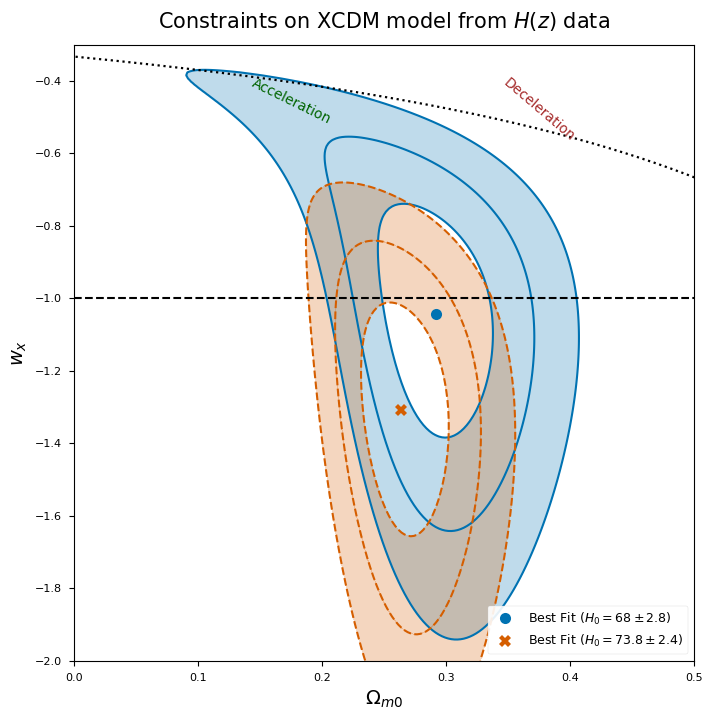

In [8]:
def main():

    try:
        data = pd.read_csv('hz_28points.csv')
        z_obs = data['z'].values
        H_obs = data['H_obs'].values
        sigma_H = data['sigma_H'].values
    except FileNotFoundError:
        print("Error: 'hz_28points.csv' not found.")
        print("Please make sure the CSV file is in the same directory as the script.")
        return

    #H0 Priors
    prior1 = {'H0_mean': 68, 'H0_sigma': 2.8}
    prior2 = {'H0_mean': 73.8, 'H0_sigma': 2.4}

    #Set up Parameter Grid
    om_m0_grid = np.linspace(0.0, 0.5, 200)
    wx_grid = np.linspace(-2.0, -0.3, 200)
    chi2_1 = np.zeros((len(wx_grid), len(om_m0_grid)))
    chi2_2 = np.zeros((len(wx_grid), len(om_m0_grid)))

    #Calculate Chi-Squared
    for i, wx in enumerate(wx_grid):
        for j, om_m0 in enumerate(om_m0_grid):
            chi2_1[i, j] = calculate_chi2_marginalized_xcdm(om_m0, wx, z_obs, H_obs, sigma_H, prior1)
            chi2_2[i, j] = calculate_chi2_marginalized_xcdm(om_m0, wx, z_obs, H_obs, sigma_H, prior2)

    #Best-Fit Points and Confidence Levels
    min_chi2_1 = np.min(chi2_1)
    idx1 = np.unravel_index(np.argmin(chi2_1), chi2_1.shape)
    best_fit_1 = (om_m0_grid[idx1[1]], wx_grid[idx1[0]])

    min_chi2_2 = np.min(chi2_2)
    idx2 = np.unravel_index(np.argmin(chi2_2), chi2_2.shape)
    best_fit_2 = (om_m0_grid[idx2[1]], wx_grid[idx2[0]])

    levels_1 = min_chi2_1 + np.array([2.30, 6.18, 11.83])
    levels_2 = min_chi2_2 + np.array([2.30, 6.18, 11.83])

    #Plotting
    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(8, 8))
    X, Y = np.meshgrid(om_m0_grid, wx_grid)

    color1 = '#0072B2'
    color2 = '#D55E00'

    ax.contourf(X, Y, chi2_1, levels=levels_1, colors=[color1], alpha=0.25)
    ax.contourf(X, Y, chi2_2, levels=levels_2, colors=[color2], alpha=0.25)
    ax.contour(X, Y, chi2_1, levels=levels_1, colors=color1, linewidths=1.5)
    ax.contour(X, Y, chi2_2, levels=levels_2, colors=color2, linewidths=1.5, linestyles='--')

    ax.plot(best_fit_1[0], best_fit_1[1], 'o', color=color1, markersize=8, markeredgecolor='k', label=r'Best Fit ($H_0 = 68 \pm 2.8$)')
    ax.plot(best_fit_2[0], best_fit_2[1], 'X', color=color2, markersize=8, markeredgecolor='k', label=r'Best Fit ($H_0 = 73.8 \pm 2.4$)')
    ax.set_xlabel(r'$\Omega_{m0}$', fontsize=14)
    ax.set_ylabel(r'$w_x$', fontsize=14)
    ax.set_title(r'Constraints on XCDM model from $H(z)$ data', fontsize=15, pad=12)
    ax.legend(loc='lower right', fontsize=9, framealpha=0.9)

    ax.axhline(y=-1.0, color='k', linestyle='--', lw=1.5,
              label=r'Flat $\Lambda$CDM ($w_x=-1$)')

    om = np.linspace(0.001, 0.5, 400)
    wx_q0 = -1.0 / (3.0 * (1.0 - om))

    ax.plot(om, wx_q0, 'k:', lw=1.6, label=r'Zero acceleration ($q_0=0$)')

    slope = np.gradient(wx_q0, om)

    def annotate_along(x_target, text, dy_pts, color):
        i = np.argmin(np.abs(om - x_target))
        angle = np.degrees(np.arctan(slope[i]))
        ax.annotate(text, xy=(om[i], wx_q0[i]), xytext=(0, dy_pts),
                    textcoords='offset points', rotation=angle,
                    rotation_mode='anchor', ha='center', va='center',
                    color=color, fontsize=10, clip_on=False)
    xmin, xmax = ax.get_xlim()
    xA = xmin + 0.35*(xmax - xmin)
    xD = xmin + 0.75*(xmax - xmin)
    annotate_along(xA, 'Acceleration', -14, 'darkgreen')
    annotate_along(xD, 'Deceleration',  14, 'brown')

    om_m0_int1, wx_int1 = get_1d_intervals(chi2_1, om_m0_grid, wx_grid, min_chi2_1, 4.0)
    om_m0_int2, wx_int2 = get_1d_intervals(chi2_2, om_m0_grid, wx_grid, min_chi2_2, 4.0)

    print("\n" + "="*50)
    print("      Numerical Results for XCDM Model Fit")
    print("="*50)

    print("\n--- Prior 1: H0 = 68.0 +/- 2.8 km/s/Mpc ---")
    print(f"Best-fit point (Ωm0, wx): ({best_fit_1[0]:.2f}, {best_fit_1[1]:.2f})")
    print(f"Minimum χ2: {min_chi2_1:.2f}")
    print(f"2σ interval for Ωm0: {om_m0_int1[0]:.2f} <= Ωm0 <= {om_m0_int1[1]:.2f}")
    print(f"2σ interval for wx:  {wx_int1[0]:.2f} <= wx <= {wx_int1[1]:.2f}")

    print("\n--- Prior 2: H0 = 73.8 +/- 2.4 km/s/Mpc ---")
    print(f"Best-fit point (Ωm0, wx): ({best_fit_2[0]:.2f}, {best_fit_2[1]:.2f})")
    print(f"Minimum χ2: {min_chi2_2:.2f}")
    print(f"2σ interval for Ωm0: {om_m0_int2[0]:.2f} <= Ωm0 <= {om_m0_int2[1]:.2f}")
    print(f"2σ interval for wx:  {wx_int2[0]:.2f} <= wx <= {wx_int2[1]:.2f}")
    print("\n" + "="*50)


def get_1d_intervals(chi2_grid, x_grid, y_grid, min_chi2, delta_chi2):

    #Interval for x-parameter
    chi2_1d_x = np.min(chi2_grid, axis=0) # Marginalize over y-axis
    x_interval_mask = (chi2_1d_x - min_chi2) < delta_chi2
    x_interval = (x_grid[x_interval_mask].min(), x_grid[x_interval_mask].max())

    #Interval for y-parameter
    chi2_1d_y = np.min(chi2_grid, axis=1) # Marginalize over x-axis
    y_interval_mask = (chi2_1d_y - min_chi2) < delta_chi2
    y_interval = (y_grid[y_interval_mask].min(), y_grid[y_interval_mask].max())

    return x_interval, y_interval


def calculate_chi2_marginalized_xcdm(om_m0, wx, z, H_obs, sigma_H, prior):
    if om_m0 < 0 or om_m0 > 1:
        return np.inf

    om_x0 = 1.0 - om_m0
    E_sq = om_m0 * (1 + z)**3 + om_x0 * (1 + z)**(3 * (1 + wx))

    if np.any(E_sq < 0):
        return np.inf
    E = np.sqrt(E_sq)
    A_sum = np.sum(E**2 / sigma_H**2)
    B_sum = np.sum(H_obs * E / sigma_H**2)
    C_sum = np.sum(H_obs**2 / sigma_H**2)

    sigma_H0_sq = prior['H0_sigma']**2
    H0_mean = prior['H0_mean']

    S_A = A_sum + 1 / sigma_H0_sq
    S_B = B_sum + H0_mean / sigma_H0_sq
    S_C = C_sum + H0_mean**2 / sigma_H0_sq

    chi2_val = S_C - S_B**2 / S_A

    return chi2_val

if __name__ == '__main__':
    main()

# FIG-3:

Grid computed in 443.5 s for grid 100x100.
Computing zero-acceleration curve (this may take a while)...


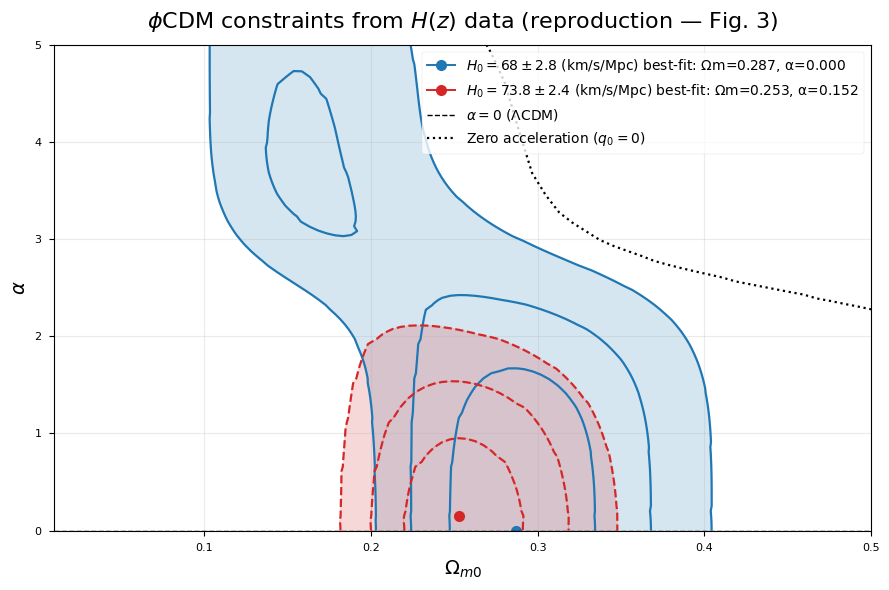


 Numerical Results for φCDM Model Fit (marginalized over H0)

--- Prior: $H_0=68\pm2.8$ (km/s/Mpc) ---
Best-fit point (Ωm0, α): (0.287, 0.000)
Minimum χ²: 19.585
2σ interval for Ωm0: 0.238 <= Ωm0 <= 0.347
2σ interval for α: 0.000 <= α <= 2.020

--- Prior: $H_0=73.8\pm2.4$ (km/s/Mpc) ---
Best-fit point (Ωm0, α): (0.253, 0.152)
Minimum χ²: 21.919
2σ interval for Ωm0: 0.213 <= Ωm0 <= 0.302
2σ interval for α: 0.000 <= α <= 1.212



In [5]:
data = pd.read_csv('hz_28points.csv')
z_arr = data['z'].values
Hobs = data['H_obs'].values
sigmaH = data['sigma_H'].values

def solve_phi_background(alpha, kappa, Omega_m0, z_init=50.0, z_final=0.0,
                         phi_init=1.0, phidot_init=0.0, rtol=1e-6, atol=1e-8):

    N_init = -np.log(1.0 + z_init)
    N_final = -np.log(1.0 + z_final)

    def rhs(N, y):
        phi, phidot = y
        a = np.exp(N)
        rho_m = 3.0 * Omega_m0 * a**(-3)
        # keep phi positive
        if phi <= 0:
            phi = 1e-12
        V = kappa * (phi**(-alpha)) if alpha >= 0 else 0.0
        rho_phi = 0.5 * phidot**2 + V
        H = np.sqrt(np.maximum((rho_m + rho_phi) / 3.0, 1e-16))
        dphi_dN = phidot / H
        dphidot_dN = (alpha * kappa * (phi**(-(alpha + 1.0)))) / H - 3.0 * phidot
        return [dphi_dN, dphidot_dN]

    y0 = [phi_init, phidot_init]
    sol = solve_ivp(rhs, (N_init, N_final), y0, dense_output=True, rtol=rtol, atol=atol, max_step=0.5)
    Ns = np.linspace(N_init, N_final, 600)
    ys = sol.sol(Ns)
    phis, phidots = ys[0], ys[1]
    zs = np.exp(-Ns) - 1.0
    a_vals = np.exp(Ns)
    rho_m_vals = 3.0 * Omega_m0 * a_vals**(-3)
    V_vals = kappa * (phis**(-alpha)) if alpha >= 0 else np.zeros_like(phis)
    rho_phi_vals = 0.5 * phidots**2 + V_vals
    H_vals = np.sqrt(np.maximum((rho_m_vals + rho_phi_vals) / 3.0, 1e-16))
    sort_idx = np.argsort(zs)
    z_sorted = zs[sort_idx]
    E_sorted = H_vals[sort_idx]
    E_of_z = interp1d(z_sorted, E_sorted, kind='cubic', bounds_error=False, fill_value='extrapolate')
    rho_phi0 = rho_phi_vals[-1]
    Omega_phi0 = rho_phi0 / 3.0
    #present-day phi, phidot, V
    phi0 = phis[-1]
    phidot0 = phidots[-1]
    V0 = V_vals[-1] if V_vals.size>0 else 0.0
    return E_of_z, Omega_phi0, phi0, phidot0, V0

def find_kappa_for_Omegap(alpha, Omega_m0, target_Omega_phi, phi_init=1.0, phidot_init=0.0):

    k = 1e-12
    Eint, O, _, _, _ = solve_phi_background(alpha, k, Omega_m0, phi_init=phi_init, phidot_init=phidot_init)
    if O == 0:
        k = 1e-6
        Eint, O, _, _, _ = solve_phi_background(alpha, k, Omega_m0, phi_init=phi_init, phidot_init=phidot_init)

    for _ in range(20):
        if O <= 0:
            k *= 10.0
        else:
            k *= (target_Omega_phi / O)
        Eint, O, _, _, _ = solve_phi_background(alpha, k, Omega_m0, phi_init=phi_init, phidot_init=phidot_init)
        if abs(O - target_Omega_phi) < 5e-3:
            return k, Eint
    return k, Eint

def marginalized_likelihood_over_H0(E_vals, Hobs, sigmaH, H0_prior_mean, H0_prior_sigma):
    invsig2 = 1.0 / (sigmaH**2)
    Acoef = 1.0 / (H0_prior_sigma**2) + np.sum((E_vals**2) * invsig2)
    beta = H0_prior_mean / (H0_prior_sigma**2) + np.sum(Hobs * E_vals * invsig2)
    gamma = (H0_prior_mean**2) / (H0_prior_sigma**2) + np.sum((Hobs**2) * invsig2)

    #log-likelihood form(we will convert to chi2 = -2 ln L)
    exponent = -0.5 * (gamma - beta**2 / Acoef)
    prefactor = 1.0 / (2.0 * np.sqrt(Acoef) * H0_prior_sigma)
    erfarg = beta / np.sqrt(2.0 * Acoef)
    term = 0.5 * (1.0 + erf(erfarg))
    LH = prefactor * np.exp(exponent) * term
    return LH

#compute 1D marginalized intervals from chi2 grid

def get_1d_intervals_from_chi2(chi2_grid, x_vals, y_vals, chi2_min, delta_chi2=4.0):
    finite_mask = np.isfinite(chi2_grid)
    if not np.any(finite_mask):
        return (np.nan, np.nan), (np.nan, np.nan)
    chi2_1d_x = np.nanmin(np.where(np.isfinite(chi2_grid), chi2_grid, np.nan), axis=1)
    chi2_1d_y = np.nanmin(np.where(np.isfinite(chi2_grid), chi2_grid, np.nan), axis=0)
    mask_x = (chi2_1d_x - chi2_min) < delta_chi2
    mask_y = (chi2_1d_y - chi2_min) < delta_chi2
    if np.any(mask_x):
        x_interval = (x_vals[mask_x].min(), x_vals[mask_x].max())
    else:
        x_interval = (np.nan, np.nan)
    if np.any(mask_y):
        y_interval = (y_vals[mask_y].min(), y_vals[mask_y].max())
    else:
        y_interval = (np.nan, np.nan)
    return x_interval, y_interval

def present_day_pressure(alpha, Om):
    """
    For given alpha and Om, find kappa so Omega_phi0 ~= 1-Om and return p_phi0 = 0.5 phidot0^2 - V0.
    If solver fails, return np.nan.
    """
    target = 1.0 - Om
    try:
        kappa, Eint = find_kappa_for_Omegap(alpha, Om, target, phi_init=1.0, phidot_init=0.0)
        # now get present-day quantities
        _, _, phi0, phidot0, V0 = solve_phi_background(alpha, kappa, Om, phi_init=1.0, phidot_init=0.0)
        p0 = 0.5 * (phidot0**2) - V0
        return p0
    except Exception:
        return np.nan

def main():
    # grid
    nOm = 100
    nAlpha = 100
    Om_vals = np.linspace(0.01, 0.5, nOm)
    alpha_vals = np.linspace(0.0, 5.0, nAlpha)

    priors = [
        (68.0, 2.8, r'$H_0=68\pm2.8$ (km/s/Mpc)', 'solid', '#1f77b4'),
        (73.8, 2.4, r'$H_0=73.8\pm2.4$ (km/s/Mpc)', 'dashed', '#d62728'),
    ]

    LH_grids = [np.zeros((nOm, nAlpha)) for _ in priors]
    chi2_grids = [np.full((nOm, nAlpha), np.inf) for _ in priors]
    best_points = []

    start = time.time()
    for i, Om in enumerate(Om_vals):
        for j, a in enumerate(alpha_vals):
            target_Omegap = 1.0 - Om
            try:
                kappa, Einterp = find_kappa_for_Omegap(a, Om, target_Omegap, phi_init=1.0, phidot_init=0.0)
            except Exception:
                continue
            Evals = Einterp(z_arr)
            for kidx, (H0m, H0s, label, linestyle, color) in enumerate(priors):
                LH = marginalized_likelihood_over_H0(Evals, Hobs, sigmaH, H0m, H0s)
                LH_grids[kidx][i, j] = LH
                chi2_grids[kidx][i, j] = -2.0 * np.log(LH) if LH > 0 else np.inf
    end = time.time()
    print(f"Grid computed in {(end - start):.1f} s for grid {nOm}x{nAlpha}.")
    #Compute zero-acceleration curve alpha(Om) numerically:
    #q0=0 <=> p_phi0 = -1  (in the code's units)
    #We'll sample Om_plot points and find alpha root for each.
    Om_plot = np.linspace(0.02, 0.5, 60)#fewer points->faster
    alpha_q0 = np.full_like(Om_plot, np.nan)

    print("Computing zero-acceleration curve (this may take a while)...")
    for idx, Om_try in enumerate(Om_plot):
        # define function f(alpha) = p_phi0(alpha,Om_try) + 1; want f(alpha)=0
        def f_alpha(a_val):
            p0 = present_day_pressure(a_val, Om_try)
            return p0 + 1.0  # root when p0 = -1
        #bracket search: sample a few alphas to find sign change
        a_samples = np.concatenate([np.linspace(0.0, 1.0, 11), np.linspace(1.0, 10.0, 10)])
        f_samples = []
        for av in a_samples:
            fv = f_alpha(av)
            f_samples.append(fv)
        f_samples = np.array(f_samples, dtype=float)

        #find an interval where sign changes
        sign_idx = np.where(np.sign(f_samples[:-1]) * np.sign(f_samples[1:]) < 0)[0]
        if sign_idx.size == 0:
            #no sign change found; skip
            alpha_q0[idx] = np.nan
            continue
        #choose first bracket
        i0 = sign_idx[0]
        a_lo = a_samples[i0]
        a_hi = a_samples[i0+1]
        try:
            root = bisect(f_alpha, a_lo, a_hi, maxiter=40, xtol=1e-3)
            alpha_q0[idx] = root
        except Exception:
            alpha_q0[idx] = np.nan
    #Plotting

    plt.style.use('seaborn-v0_8-paper')
    fig, ax = plt.subplots(figsize=(9, 6))

    contour_levels = [2.30, 6.17, 11.83]  # Δχ² for 2 parameters -> 1,2,3σ
    for kidx, (H0m, H0s, label, linestyle, color) in enumerate(priors):
        chi2 = chi2_grids[kidx]
        finite_mask = np.isfinite(chi2)
        if not np.any(finite_mask):
            continue
        chi2_min = np.nanmin(chi2[finite_mask])
        min_idx = np.unravel_index(np.nanargmin(chi2), chi2.shape)
        Om_best = Om_vals[min_idx[0]]
        alpha_best = alpha_vals[min_idx[1]]
        best_points.append((label, Om_best, alpha_best, chi2_min))

        delta_chi2 = chi2 - chi2_min

        Om_mesh, Alpha_mesh = np.meshgrid(Om_vals, alpha_vals, indexing='xy') #shapes (nAlpha, nOm)
        delta_plot = delta_chi2.T

        cf = ax.contourf(Om_mesh, Alpha_mesh, delta_plot, levels=[0.0] + contour_levels, alpha=0.18, colors=[color])
        cs = ax.contour(Om_mesh, Alpha_mesh, delta_plot, levels=contour_levels, colors=[color], linestyles=linestyle, linewidths=1.6)
        ax.plot(Om_best, alpha_best, marker='o', color=color, markersize=8, markeredgecolor='k',
                label=f'{label} best-fit: Ωm={Om_best:.3f}, α={alpha_best:.3f}')

    ax.set_xlabel(r'$\Omega_{m0}$', fontsize=14)
    ax.set_ylabel(r'$\alpha$', fontsize=14)
    ax.set_title(r'$\phi$CDM constraints from $H(z)$ data (reproduction — Fig. 3)', fontsize=16, pad=12)
    ax.set_xlim(Om_vals.min(), Om_vals.max())
    ax.set_ylim(alpha_vals.min(), alpha_vals.max())
    ax.grid(alpha=0.25)

    ax.axhline(0.0, color='k', lw=1.0, ls='--', label=r'$\alpha=0$ (ΛCDM)')

    valid_mask = np.isfinite(alpha_q0)
    if np.any(valid_mask):
        ax.plot(Om_plot[valid_mask], alpha_q0[valid_mask], color='k', lw=1.6, ls=':', label=r'Zero acceleration ($q_0=0$)')

        xmin, xmax = ax.get_xlim()
        xA = xmin + 0.35*(xmax - xmin)
        xD = xmin + 0.75*(xmax - xmin)
        iA = np.argmin(np.abs(Om_plot - xA))
        iD = np.argmin(np.abs(Om_plot - xD))


    ax.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()
    print("\n" + "=" * 60)
    print(" Numerical Results for φCDM Model Fit (marginalized over H0)")
    print("=" * 60)
    for kidx, (H0m, H0s, label, _, _) in enumerate(priors):
        chi2 = chi2_grids[kidx]
        finite_mask = np.isfinite(chi2)
        if not np.any(finite_mask):
            print(f"\n--- Prior {label}: no finite chi2 values ---")
            continue
        chi2_min = np.nanmin(chi2[finite_mask])
        min_idx = np.unravel_index(np.nanargmin(chi2), chi2.shape)
        Om_best = Om_vals[min_idx[0]]
        alpha_best = alpha_vals[min_idx[1]]
        #1D intervals using Δχ² = 4 for 2σ
        Om_interval, alpha_interval = get_1d_intervals_from_chi2(chi2, Om_vals, alpha_vals, chi2_min, delta_chi2=4.0)

        print(f"\n--- Prior: {label} ---")
        print(f"Best-fit point (Ωm0, α): ({Om_best:.3f}, {alpha_best:.3f})")
        print(f"Minimum χ²: {chi2_min:.3f}")
        if not any(np.isnan(Om_interval)):
            print(f"2σ interval for Ωm0: {Om_interval[0]:.3f} <= Ωm0 <= {Om_interval[1]:.3f}")
        else:
            print("2σ interval for Ωm0: could not determine (no finite region)")
        if not any(np.isnan(alpha_interval)):
            print(f"2σ interval for α: {alpha_interval[0]:.3f} <= α <= {alpha_interval[1]:.3f}")
        else:
            print("2σ interval for α: could not determine (no finite region)")
    print("\n" + "=" * 60)

if __name__ == "__main__":
    main()
